# Analyzing customer messages - custom model

This notebook demonstrates Python code for analyzing customer messages using Watson Natural Language Understanding with default language models and a custom language model

- Step 0: Define some helper functions
- Step 1: Download sample customer messages 
- Step 2: Look up Natural Language Understanding API key & model ID
- Step 3: Analyze sample customer messages
- Step 4: Visualize results for customer messages

## Step 0: Define some helper functions

Run these cells to make processing further on in this notebook simpler.

In [1]:
# Loop through all sample customer questions and problems, extracting keywords and sematic roles
# Default model 
#
def analyze_default( msgs ):
    results_list = []
    for message in msgs:
        result = nlu.analyze( text=message, features=Features( keywords=KeywordsOptions(), semantic_roles=SemanticRolesOptions() ) ).get_result()
        keywords = []
        for keyword in result["keywords"]:
            keywords.append( keyword["text"] )
        action  = ""
        obj     = ""
        if( "semantic_roles" in result ):
            if( len( result["semantic_roles"] ) > 0 ):
                if( "action" in result["semantic_roles"][0] ):
                    action  = result["semantic_roles"][0]["action"]["normalized"]
                if( "object" in result["semantic_roles"][0] ):
                    obj = result["semantic_roles"][0]["object"]["text"]
        results_list.append( { "header"   : "-------------------------------------------------------------",
                               "message"  : message,
                               "keywords" : keywords,
                               "action"   : action,
                               "object"   : obj,
                               "spacer"   : "" } )
    return results_list


# Loop through all sample customer questions and problems, extracting entities
# Custom model 
#
def analyze_custom( msgs ):
    results_list = []
    for message in msgs:
        result = nlu.analyze( text=message, features=Features( entities=EntitiesOptions( model=custom_model_id ) ) ).get_result()
        result_entities = { "action" : [], "docs" : [], "obj" : [], "persona" : [], "tech" : [] }
        if( "entities" in result ):
            for entity in result["entities"]:
                result_entities[ entity["type"] ].append( entity["text"] )
        results_list.append( { "header"  : "-------------------------------------------------------------",
                               "message" : message,
                               "action"  : result_entities["action"],
                               "docs"    : result_entities["docs"],
                               "obj"     : result_entities["obj"],
                               "persona" : result_entities["persona"],
                               "tech"    : result_entities["tech"],
                               "spacer"  : "" } )
    return results_list

In [2]:
# Define some helper functions for counting the most common keywords and entities
#
from collections import OrderedDict


# Counting words in default results
#

def count_default_actions( results_list ):
    actions = {}
    for entry in results_list:
        action = entry["action"]
        if( "" != action ):
            if( action not in actions ):
                actions[action] = 0
            actions[action] += 1
    common_actions = dict( [ (k,v) for k,v in actions.items() if v > 1 ] )
    ordered_common_actions = OrderedDict( sorted( common_actions.items(), key=lambda x:x[1], reverse=True ) )
    return ordered_common_actions


def count_default_keywords( results_list ):
    all_keywords = {}
    for entry in results_list:
        keywords = entry["keywords"]
        for keyword in keywords:
            if( keyword not in all_keywords ):
                all_keywords[keyword] = 0
            all_keywords[keyword] += 1

    common_keywords = dict( [ (k,v) for k,v in all_keywords.items() if v > 2 ] )

    ordered_common_keywords = OrderedDict( sorted( common_keywords.items(), key=lambda x:x[1], reverse=True ) )
    return ordered_common_keywords


# Counting words in custom results
#

def count_custom( results_list, entity_type ):
    entities = {}
    for entry in results_list:
        words = entry[entity_type]
        for word in words:
            if( "" != word ):
                if( word not in entities ):
                    entities[word] = 0
                entities[word] += 1
    common_entities = dict( [ (k,v) for k,v in entities.items() if v > 1 ] )
    ordered_common_entities = OrderedDict( sorted( common_entities.items(), key=lambda x:x[1], reverse=True ) )
    return ordered_common_entities

In [3]:
# Define some helper functions for plotting the word counts bar charts
#
import random
from matplotlib import colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

def random_colours( num ):
    rand_indexes = random.sample(range(0, len( mcolors.CSS4_COLORS.keys() ) - 1 ), num )
    colour_list = [ list( mcolors.CSS4_COLORS.keys() )[i] for i in rand_indexes ]
    return colour_list

def plot_words( title, ordered_words ):
    values    = ordered_words.values()
    labels    = list( ordered_words.keys() )
    num_bars  = len( labels )
    positions = np.arange( num_bars )
    colours   = random_colours( num_bars )
    
    fig, axs = plt.subplots( 1, 1, figsize=( 20, 6 ) )
    axs.bar( positions, values, color=colours, edgecolor="black" )
    plt.xticks( positions, labels ) 
    plt.tick_params( axis='both', which='major', labelsize=16)
    
    print( title )

## Step 1: Import sample customer messages

This sample data set is from the Watson Studio Community: [Customer messages](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/015ddef6a868441188268a123404f744)

In [4]:
# Import the data into a DataFrame by reading from the URL
#
import pandas as pd
import io
import requests
url = "https://dataplatform.cloud.ibm.com/data/exchange-api/v1/entries/015ddef6a868441188268a123404f744/data?accessKey=1e878a1edda3c1c8b3f9defb83e5c84b"
csv_contents = io.StringIO( requests.get( url ).content.decode( "utf-8" ) )
all_messages = pd.read_csv( csv_contents, header=None )
all_messages.head()

,0,1
0,excuse me,hi
1,Good evening,hi
2,Good morning,hi
3,good morning,hi
4,Good morning can you help me upload a shapefile?,question


In [5]:
# For analysis purposes, we want just the questions and problems, not the short, social messages labeled as "hi".
# And we want just the text of those questions and problems, not the labels column.
#
questions_problems_only = all_messages[all_messages.iloc[:,1] != "hi" ].reset_index(drop=True)
questions_problems_text = list( questions_problems_only.iloc[:,0] )
questions_problems_text[0:6]

['Good morning can you help me upload a shapefile?',
 'Good night where to place my file to import it into notebook?',
 'hai how can i do analyze with csv file is there any tutorial on it',
 'Having issues setup WML service',
 'hello - Im trying to edit a notebook and the circie just keeps spinning. any idea to get around this?',
 'hello how can i download a csv file from my notebook?']

## Step 2: Look up API key, URL, and custom model ID

### Natural Language Understanding API key and URL
1. From the **Services** menu in Watson Studio, right-click "Watson Services" and then open the link in a new browser tab
2. In the new Watson services tab, from the **Action** menu beside the Natural Language Understanding instance, select "Manage in IBM Cloud"
3. In the service details page that opens, click **Service credentials**, then expand credentials to view them, and then copy the apikey and URL

### Custom language model ID
1. On the <b>Versions</b> page in your Knowledge Studio workspace, expand the <b>Deployed Models</b> list
2. Copy the <b>Model ID</b>

In [6]:
apikey = "" # <-- PASTE YOUR APIKEY HERE
url    = "" # <-- PASTE YOUR SERVICE URL HERE
custom_model_id = "" # <-- PASTE THE MODEL ID FROM KNOWLEDGE STUDIO HERE

## Step 3: Analyze customer messages

In [ ]:
!pip install --upgrade "ibm-watson>=3.1.2"

In [8]:
# Import some libraries and instantiate a natural language understanding object
#
import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, ConceptsOptions, EmotionOptions, EntitiesOptions, KeywordsOptions, SemanticRolesOptions, SentimentOptions, CategoriesOptions, SyntaxOptions, SyntaxOptionsTokens
nlu = NaturalLanguageUnderstandingV1( version='2019-07-12', iam_apikey=apikey, url=url )

### Basic example

In [9]:
questions_problems_text[0]

'Good morning can you help me upload a shapefile?'

In [10]:
# Default languag model
#
nlu.analyze( text=questions_problems_text[0], features=Features( keywords=KeywordsOptions() ) ).get_result()

{'usage': {'text_units': 1, 'text_characters': 48, 'features': 1},
 'language': 'en',
 'keywords': [{'text': 'Good morning', 'relevance': 0.999999, 'count': 1},
  {'text': 'shapefile', 'relevance': 0.00131, 'count': 1}]}

In [11]:
# Custom language model
#
nlu.analyze( text=questions_problems_text[0], features=Features( entities=EntitiesOptions( model=custom_model_id ) ) ).get_result()

{'usage': {'text_units': 1, 'text_characters': 48, 'features': 1},
 'language': 'en',
 'entities': [{'type': 'action',
   'text': 'upload',
   'disambiguation': {'subtype': ['NONE']},
   'count': 1,
   'confidence': 0.999676},
  {'type': 'obj',
   'text': 'shapefile',
   'disambiguation': {'subtype': ['NONE']},
   'count': 1,
   'confidence': 0.997579}]}

### Analyze customer questions and problems using the NLU default model

In [12]:
default_results = analyze_default( questions_problems_text )

In [13]:
default_results

[{'header': '-------------------------------------------------------------',
  'message': 'Good morning can you help me upload a shapefile?',
  'keywords': ['Good morning', 'shapefile'],
  'action': 'help',
  'object': 'me upload a shapefile',
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Good night where to place my file to import it into notebook?',
  'keywords': ['Good night', 'file', 'notebook'],
  'action': 'to place',
  'object': 'to import it into notebook',
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'hai how can i do analyze with csv file is there any tutorial on it',
  'keywords': ['csv file', 'hai', 'tutorial'],
  'action': 'do',
  'object': 'analyze',
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Having issues setup WML service',
  'keywords': ['issues setup WML service'],
  'action': '',
 

### Analyze customer questions and problems using the custom model

In [14]:
custom_results = analyze_custom( questions_problems_text )

In [19]:
custom_results

[{'header': '-------------------------------------------------------------',
  'message': 'Good morning can you help me upload a shapefile?',
  'action': ['upload'],
  'docs': [],
  'obj': ['shapefile'],
  'persona': [],
  'tech': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Good night where to place my file to import it into notebook?',
  'action': ['import'],
  'docs': [],
  'obj': ['notebook'],
  'persona': [],
  'tech': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'hai how can i do analyze with csv file is there any tutorial on it',
  'action': ['analyze'],
  'docs': ['tutorial'],
  'obj': [],
  'persona': [],
  'tech': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Having issues setup WML service',
  'action': ['setup'],
  'docs': [],
  'obj': [],
  'persona': [],
  'tech': ['WML'],
  '

## Step 4: Visualize results for customer messages

Count the important words, and then plot bar charts to show the most common words.

### Count up & visualize results for default language model

In [23]:
default_actions = count_default_actions( default_results )
default_keywords = count_default_keywords( default_results )

Default: Actions


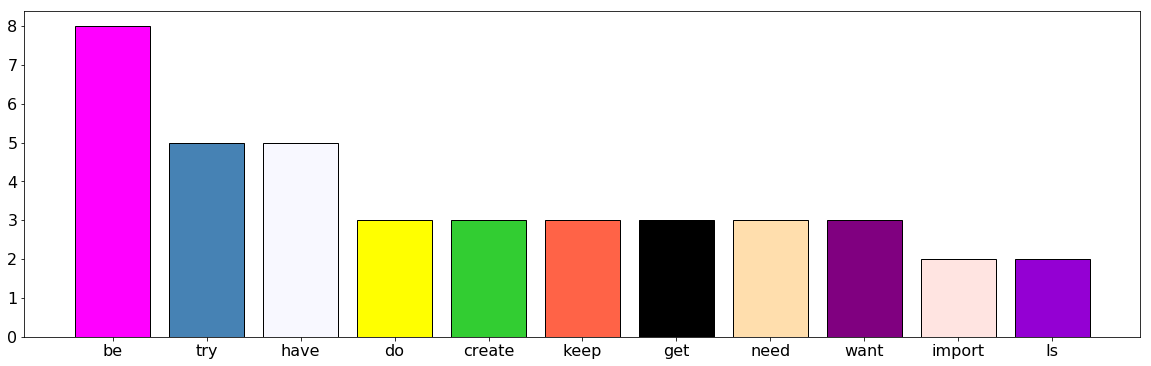

In [105]:
plot_words( "Default: Actions", default_actions )

Default: Keywords


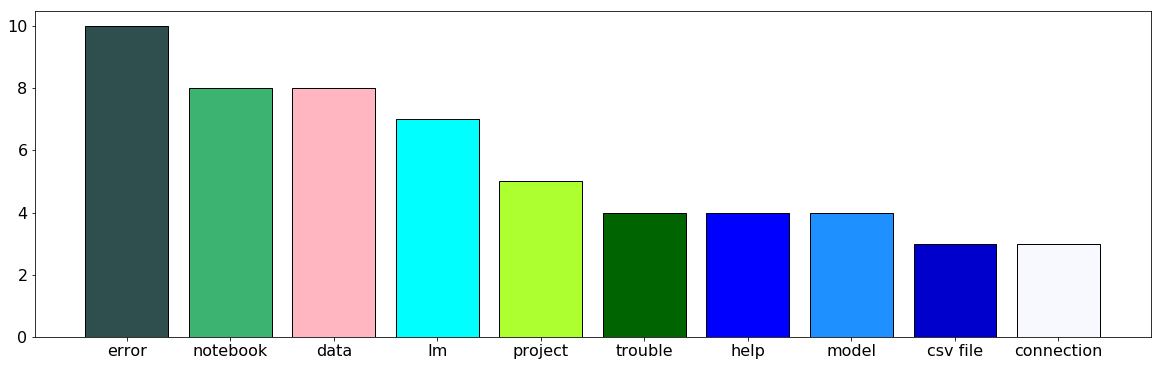

In [104]:
plot_words( "Default: Keywords", default_keywords )

### Count up & visualize results for custom model

In [26]:
custom_action  = count_custom( custom_results, "action" )
custom_docs    = count_custom( custom_results, "docs" )
custom_obj     = count_custom( custom_results, "obj" )
custom_persona = count_custom( custom_results, "persona" )
custom_tech    = count_custom( custom_results, "tech" )

Custom: Actions


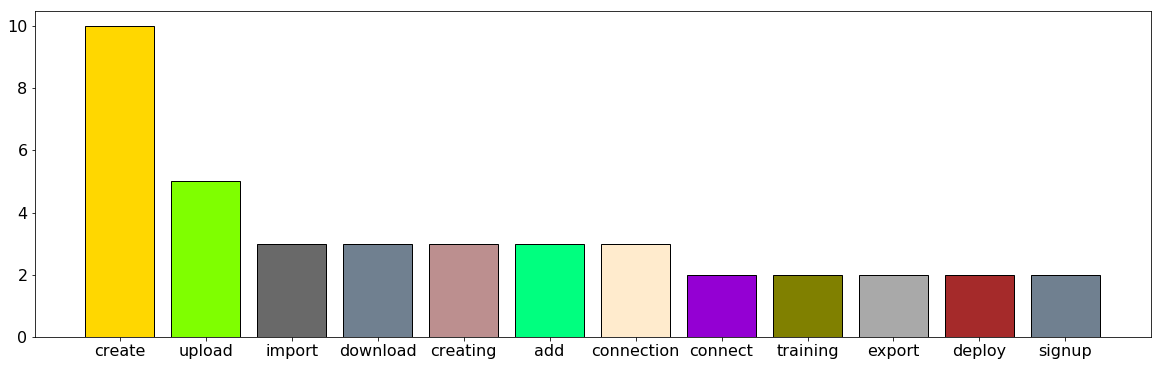

In [103]:
plot_words( "Custom: Actions", custom_action )

Custom: Objects


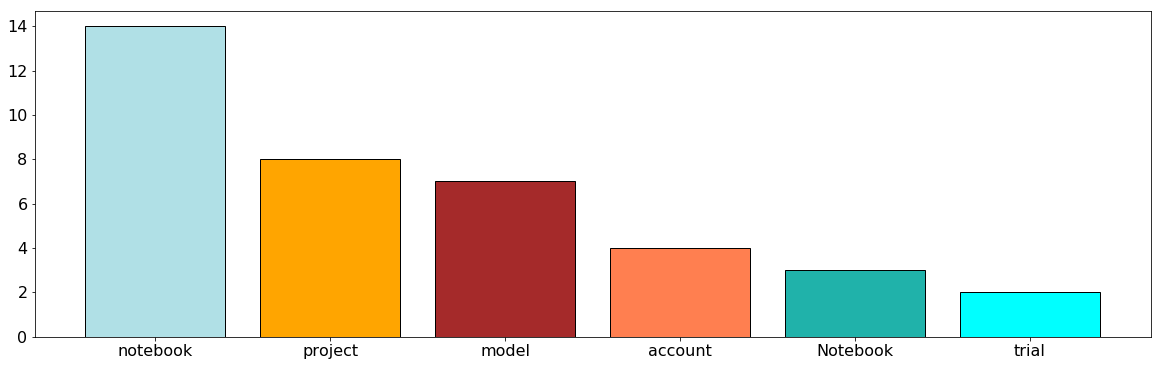

In [102]:
plot_words( "Custom: Objects", custom_obj )

Custom: Technologies


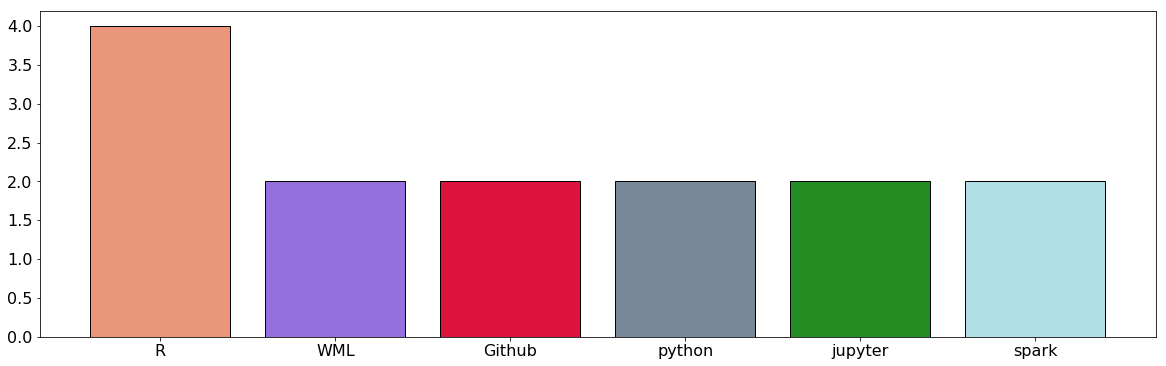

In [101]:
plot_words( "Custom: Technologies", custom_tech )

### Side-by-side comparison

In [119]:
values_default_action      = list( default_actions.values() )[0:6]
labels_default_action      = list( default_actions.keys() )[0:6]
num_bars_default_action    = len( labels_default_action )
positions_default_action   = np.arange( num_bars_default_action )
colours_default_action     = random_colours( num_bars_default_action )

values_default_keywords    = list( default_keywords.values() )[0:6]
labels_default_keywords    = list( default_keywords.keys() )[0:6]
num_bars_default_keywords  = len( labels_default_keywords )
positions_default_keywords = np.arange( num_bars_default_keywords )
colours_default_keywords   = random_colours( num_bars_default_keywords )

values_custom_action       = list( custom_action.values() )[0:6]
labels_custom_action       = list( custom_action.keys() )[0:6]
num_bars_custom_action     = len( labels_custom_action )
positions_custom_action    = np.arange( num_bars_custom_action )
colours_custom_action      = random_colours( num_bars_custom_action )

values_custom_obj          = list( custom_obj.values() )
labels_custom_obj          = list( custom_obj.keys() )
num_bars_custom_obj        = len( labels_custom_obj )
positions_custom_obj       = np.arange( num_bars_custom_obj )
colours_custom_obj         = random_colours( num_bars_custom_obj )

values_custom_tech         = list( custom_tech.values() )
labels_custom_tech         = list( custom_tech.keys() )
num_bars_custom_tech       = len( labels_custom_tech )
positions_custom_tech      = np.arange( num_bars_custom_tech )
colours_custom_tech        = random_colours( num_bars_custom_tech )

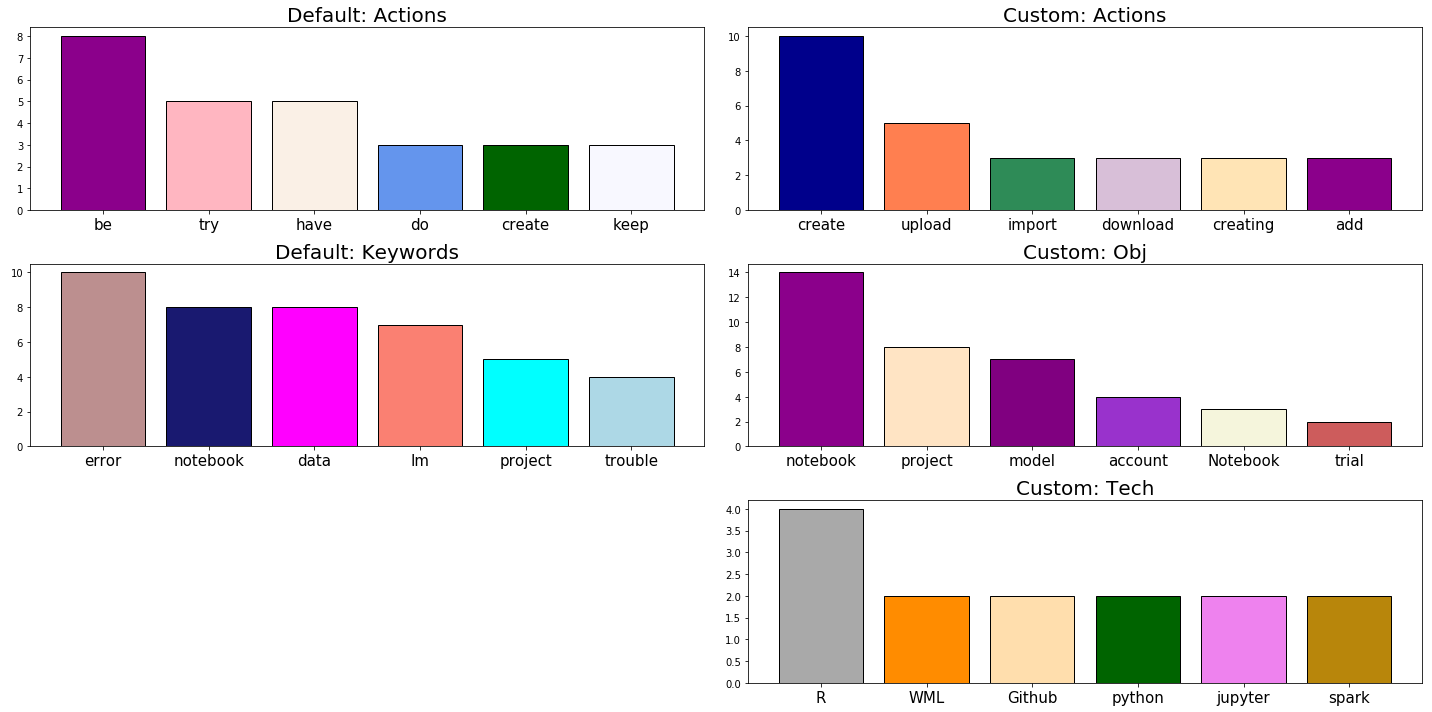

In [121]:
fig, axs = plt.subplots( 3, 2, figsize=( 20, 10 ) )
axs[0,0].bar( positions_default_action,   values_default_action,   color=colours_default_action,   edgecolor="black" )
axs[1,0].bar( positions_default_keywords, values_default_keywords, color=colours_default_keywords, edgecolor="black" )
axs[0,1].bar( positions_custom_action,    values_custom_action,    color=colours_custom_action,    edgecolor="black" )
axs[1,1].bar( positions_custom_obj,       values_custom_obj,       color=colours_custom_obj,       edgecolor="black" )
axs[2,1].bar( positions_custom_tech,      values_custom_tech,      color=colours_custom_tech,      edgecolor="black" )
axs[0,0].set_title( 'Default: Actions', fontsize=20 )
axs[1,0].set_title( 'Default: Keywords', fontsize=20  )
axs[0,1].set_title( 'Custom: Actions',  fontsize=20  )
axs[1,1].set_title( 'Custom: Obj',      fontsize=20  )
axs[2,1].set_title( 'Custom: Tech',     fontsize=20  )
plt.sca(axs[0,0])
plt.xticks( positions_default_action,   labels_default_action,   fontsize=15 )
plt.sca(axs[1,0])
plt.xticks( positions_default_keywords, labels_default_keywords, fontsize=15 )
plt.sca(axs[0,1])
plt.xticks( positions_custom_action,    labels_custom_action,    fontsize=15 )
plt.sca(axs[1,1])
plt.xticks( positions_custom_obj,       labels_custom_obj,       fontsize=15 )
plt.sca(axs[2,1])
plt.xticks( positions_custom_tech,      labels_custom_tech,      fontsize=15 )
axs[2,0].axis('off')
fig.tight_layout()
plt.show()

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.